In [ ]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, validation_curve 
from sklearn.model_selection import RandomizedSearchCV 
import pickle

In [4]:
#close previous plots if needed
%matplotlib inline
plt.close('all')

In [12]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
#load preprossed file
%cd /content/drive/My Drive/kickStarter
df = pd.read_csv('cleandf.csv')
df.set_index('id',inplace=True)
df.info()

/content/drive/My Drive/kickStarter
<class 'pandas.core.frame.DataFrame'>
Int64Index: 180679 entries, 1124922936 to 1126079486
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   blurb           180677 non-null  object 
 1   country         180679 non-null  object 
 2   slug            180679 non-null  object 
 3   staff_pick      180679 non-null  bool   
 4   state           180679 non-null  int64  
 5   campaignPeriod  180679 non-null  int64  
 6   goalUsd         180679 non-null  float64
 7   category_name   180679 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 11.2+ MB


In [14]:
df.head()

,blurb,country,slug,staff_pick,state,campaignPeriod,goalUsd,category_name
id,,,,,,,,
1124922936,Bringing deliciously fresh snacking to every g...,US,palmetto-pork-skins,False,0,30,25000.000,Food Trucks
1479488174,Warm hands and full access to your camera dial...,NO,photography-gloves-extend-your-session-in-style,False,1,32,13905.834,Camera Equipment
2077771673,Enamel pins dedicated to my Grandpa and his di...,US,eat-shit-a-memorial-pin-campaign,False,1,31,250.000,Accessories
2008689997,"To Rise In Challenge is a brand, lifestyle, me...",US,tric-clothing-co,False,1,30,4000.000,Apparel
1113925398,Inspiring girls & young women. Join me as I cr...,AU,womens-gold-medalists-rio-2016,True,1,31,37339.208,Graphic Design


# Model w/out NLP

In [10]:
#split
target='state'
X = df.drop(columns=['state','blurb','slug'])
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max() )

Baseline Accuracy: 0.5817369225766726


## random forest

In [39]:
#model with default hyper-parameters
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

In [40]:
print('Training Accuracy:', model.score(X_train, y_train) )
print('Validation Accuracy:', model.score(X_val, y_val) )

Training Accuracy: 0.9404813792435469
Validation Accuracy: 0.7695926499889307


In [12]:
#random forest hyper-parameter tuning

clf = make_pipeline(OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(random_state=42, n_jobs = -1))

param_grid = {'simpleimputer__strategy':['median','mean'], # 2 possible values
             'randomforestclassifier__max_depth':range(5,35,5), # 6 possible values
             'randomforestclassifier__n_estimators':range(25,100,25), # 3 possible values
              'randomforestclassifier__max_samples':np.arange(0.2, 1, 0.2)} # 4 possible values

model_rfrs = RandomizedSearchCV(clf,
                         param_distributions = param_grid,
                         n_iter = 25,
                         n_jobs=-1,
                         cv = 5,
                         verbose = 10)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  9.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [13]:
print('Training Accuracy:', model_rfrs.score(X_train, y_train) )
print('Validation Accuracy:', model_rfrs.score(X_val, y_val) )

Training Accuracy: 0.8661436389171389
Validation Accuracy: 0.8647332300199247


In [18]:
#save model_rfrs 
MODEL_FILEPATH = '/content/drive/My Drive/kickStarter/models/rfrsNoNLP'
pickle.dump(model_rfrs, open(MODEL_FILEPATH, 'wb'))

## XGB

In [62]:
#XGB hyper-parameter tuning
from xgboost import XGBClassifier

clf = make_pipeline(OrdinalEncoder(),
                   SimpleImputer(),
                   XGBClassifier(random_state=42, n_jobs = -1))

param_grid = {'simpleimputer__strategy':['median','mean'],
             'xgbclassifier__max_depth':range(5,35,5), 
             'xgbclassifier__n_estimators':range(25,100,25),
             'xgbclassifier__learning_rate':[0.01, 0.1, 0.2, 0.4, 1]
              } 

model_xgbrs = RandomizedSearchCV(clf, 
                               param_distributions = param_grid,
                               n_iter = 25,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 10)
model_xgbrs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 22.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
print('Training Accuracy:', model_xgbrs.score(X_train, y_train) )
print('Validation Accuracy:', model_xgbrs.score(X_val, y_val) )

## visuals & ROC curve

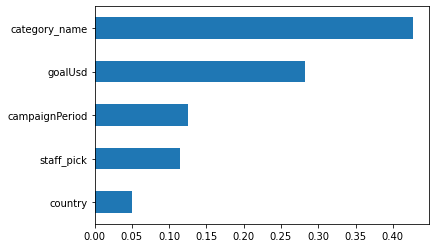

In [14]:
#rank features by importance
best_estimator = model_rfrs.best_estimator_
importances = best_estimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances,index=features).sort_values().tail(10).plot(kind='barh');

In [23]:
model_rfrs.classes_

array(['failed', 'successful'], dtype=object)

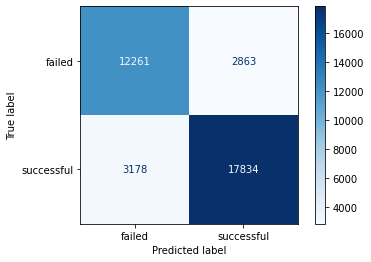

In [30]:
#plot confusion matrix
plot_confusion_matrix(model_rfrs, X_val,y_val, values_format = '.0f', display_labels=['failed', 'successful'],cmap=plt.cm.Blues);

In [15]:
#classification report
print(classification_report(y_val, model_rfrs.predict(X_val), target_names=['failed', 'successful']))

              precision    recall  f1-score   support

      failed       0.83      0.85      0.84     15124
  successful       0.89      0.88      0.88     21012

    accuracy                           0.86     36136
   macro avg       0.86      0.86      0.86     36136
weighted avg       0.87      0.86      0.86     36136



In [ ]:
#address imbalanced class issue by using ROC curve

# Get predicted probabilities from model
y_pred_prob = model_rfrs.predict_proba(X_val)[:,-1]

# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary and then dataframe
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr, 
        'thresholds': thresholds}

results = pd.DataFrame(data)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


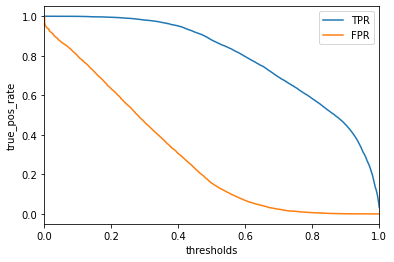

In [27]:
#visual of TPR and FPR
sns.lineplot(results['thresholds'], results['true_pos_rate'], ci = None)
sns.lineplot(results['thresholds'], results['false_pos_rate'], ci = None)
plt.legend(["TPR", 'FPR'])
plt.xlim(0, 1)
plt.show();

In [ ]:
#calculate the g-mean metric for each threshold
results['Gmean'] = np.sqrt(results['true_pos_rate'] * (1-results['false_pos_rate']))
#max g-mean value is the optimal threshold
results.sort_values(by='Gmean',ascending=False).head(1)

In [38]:
#calculate accuracy with new threshold
y_pred_prob[y_pred_prob>= 0.867155] = 1
y_pred_prob[y_pred_prob < 0.867155] = 0
accuracy_score(y_val, y_pred_prob)

0.8437569183086119

# Model with NLP

In [4]:
import nltk
import re
import spacy
import en_core_web_sm
import string as str

In [ ]:
#download all nltk modules
nltk.download()

In [8]:
nlp = en_core_web_sm.load()


In [8]:
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in str.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    text = np.str_(text)
    return text

In [ ]:
blurb_features = df['blurb'].apply(lambda x: nlp(x).vector)
blurb_features.shape
